In [1]:
from google.colab import drive                            # Mounting the drive to load the dataset
drive.mount('/content/drive')

Mounted at /content/drive


Que 1. Apply pre-emphasis to the signal.

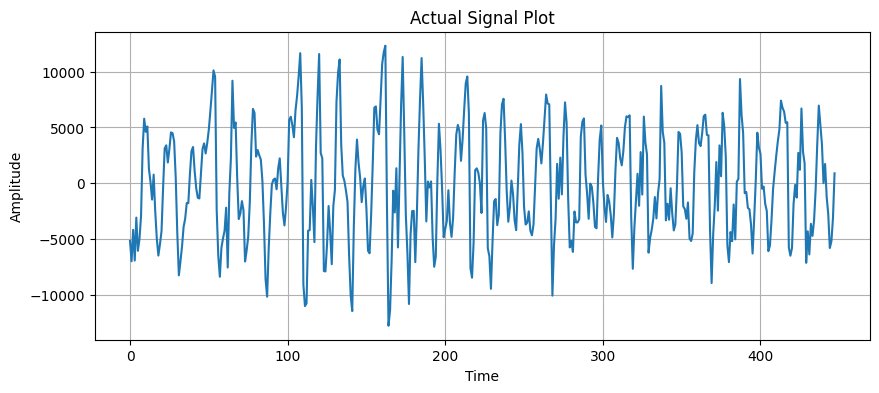

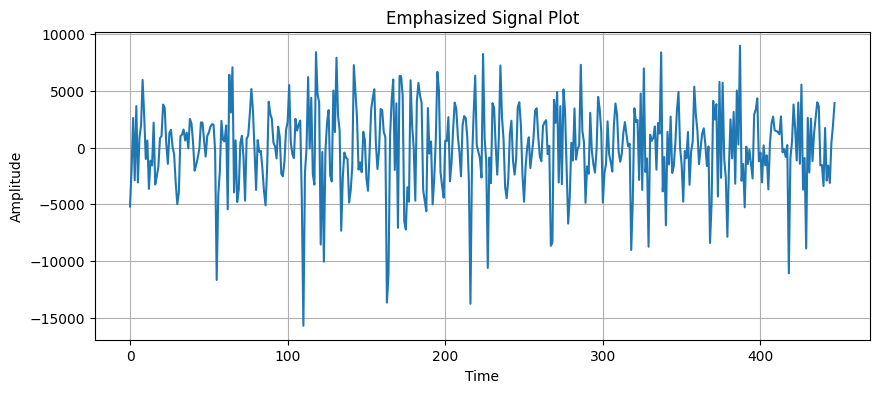

In [109]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Loading the audio file and finding it's signal and sample rate
audio_file = '/content/drive/MyDrive/Assignment2_Speech/sounds/uh.wav'
sample_rate, audio_signal = wavfile.read(audio_file)

# Defining the pre-emphasis coefficient
alpha = 0.97

# Applying pre-emphasis to the audio signal
emphasized_signal = np.append(audio_signal[0], audio_signal[1:] - alpha * audio_signal[:-1])

# Now, 'emphasized_signal' contains the pre-emphasized audio data

plt.figure(figsize=(10, 4))
plt.plot(audio_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Actual Signal Plot')
plt.grid()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(emphasized_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Emphasized Signal Plot')
plt.grid()
plt.show()


Que 2. Next, compute and plot a single narrowband magnitude spectrum slice using a Hamming window of duration = 30 ms on a segment near the centre of the given audio file.

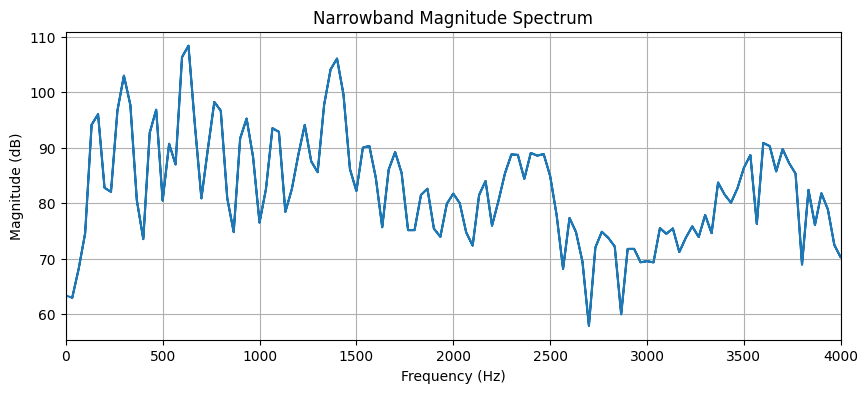

In [110]:
# Defining the window duration in seconds and window size
window_duration = 0.03  # 30 ms
window_size = int(window_duration * sample_rate)

# Selecting a segment near the center of the audio
center_sample = len(audio_signal) // 2
segment_start = center_sample - window_size // 2
segment_end = center_sample + window_size // 2

# Applying a Hamming window to the segment
hamming_window = np.hamming(window_size)
segment = audio_signal[segment_start:segment_end] * hamming_window

# Computing the magnitude spectrum using FFT
magnitude_spectrum = np.abs(np.fft.fft(segment))

# Frequency axis in Hertz
frequency_axis = np.fft.fftfreq(window_size, d=1.0 / sample_rate)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 4))
plt.plot(abs(frequency_axis), 20 * np.log10(magnitude_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Narrowband Magnitude Spectrum')
plt.grid()
plt.xlim(0, sample_rate / 2)  # Displaying only positive frequencies
plt.show()


Que 3. With the same 30 ms segment of part 2, compute the autocorrelation coefficients required for the LPC calculation up to p=10. Use the Levinson-Durbin recursion to compute the LP coefficients from the autocorrelation coefficients for each order p = 2,4,6,8,10. Plot error signal
energy (i.e. square of gain) vs p.

In [112]:
def autocorrelation(x):
    N = len(x)
    autocorr = [0] * N

    for k in range(N):
        for n in range(k, N):
            autocorr[k] += x[n] * x[n - k]

    autocorr = [corr / N for corr in autocorr]

    return autocorr

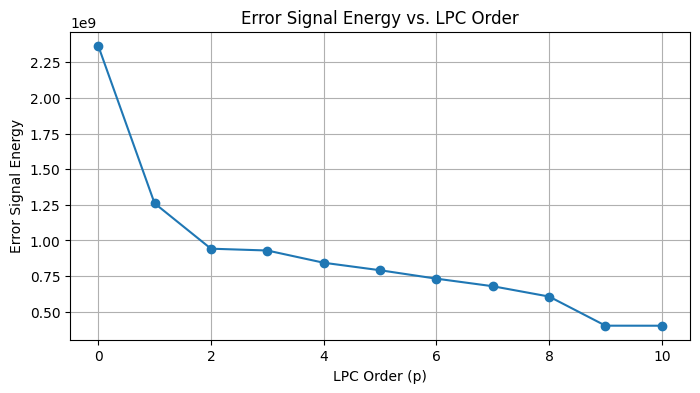

In [115]:
# Defining the order ( p = 10) this will also calculate other orders
p = 10

# Compute autocorrelation coefficients for each order p
autocorr = np.correlate(segment, segment, mode='full')
 #autocorr = autocorrelation(segment)
a = np.zeros((11,11))
gain_values = np.zeros(11)

r = autocorr[len(segment) - 1:len(segment) - 1 + p + 1]  # Autocorrelation coefficients up to order p
E = np.zeros(11)

# Levinson-Durbin recursion to compute LPC coefficients
a[0][0] = 1
E[0] = r[0]
for i in range(1, p + 1):
    c = 0
    for j in range (1, i):
      c += a[i-1][j] * r[i-j]
    k = (r[i] - c) / E[i-1]
    a[i][i] = k
    for j in range(1, i):
      a[i][j] = a[i-1][j] - k * a[i-1][i-j]
    E[i] = E[i - 1] * (1 - k * k)
    gain_values[i] = np.sqrt(E[i])
    a[i][0] = 1

x = [i for i in range(p+1)]
# Plotting error signal energy vs. LPC order (p)
plt.figure(figsize=(8, 4))
plt.plot(x, E, marker='o', linestyle='-')
plt.xlabel('LPC Order (p)')
plt.ylabel('Error Signal Energy')
plt.title('Error Signal Energy vs. LPC Order')
plt.grid()
plt.show()


Que 4. Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment

<Figure size 1200x400 with 0 Axes>

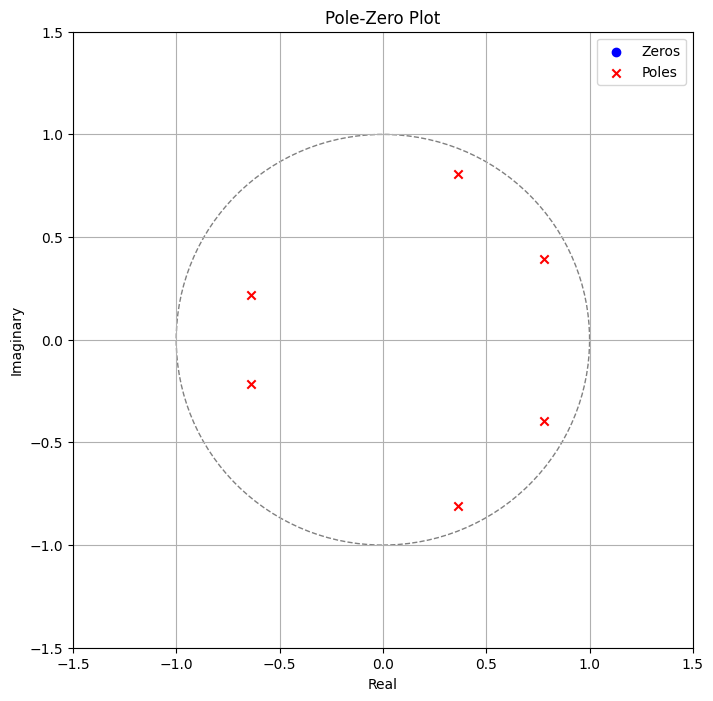

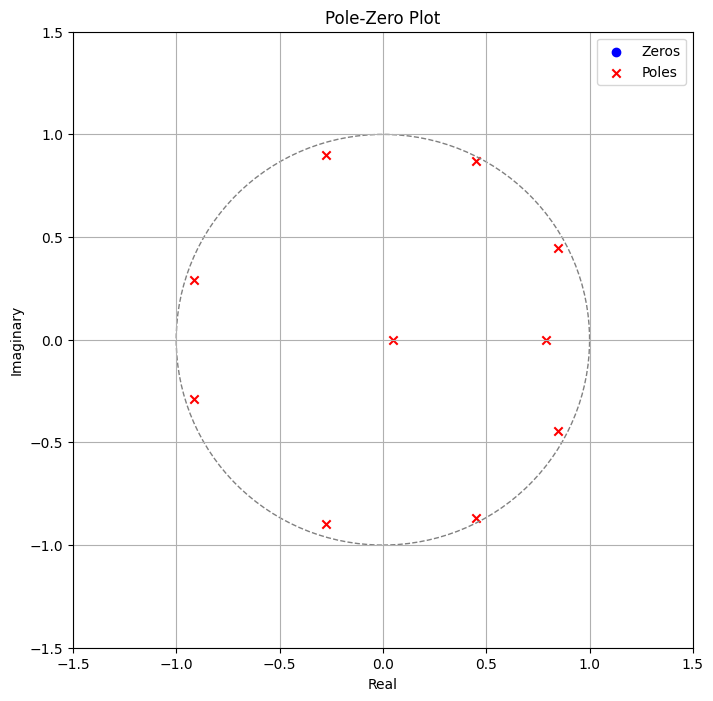

In [97]:
from scipy.signal import lfilter, freqz
from scipy import signal

# Defining LPC orders for which we will calculate Pole Zero plots
p_values = [6, 10]

# Plotting the pole-zero plots
plt.figure(figsize=(12, 4))
for p in p_values:
    # Compute the poles and zeros
    den = [a[p][0],*(-a[p][1:p+1])]
    num = gain_values[p]

    # Calculating the poles and zeros
    zeros, poles, _ = signal.tf2zpk(num, den)

    # Creating a pole-zero plot
    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='b', label='Zeros')
    plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', label='Poles')

    # Adding a unit circle for reference
    unit_circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='dashed')
    plt.gca().add_patch(unit_circle)

    # Setting axis limits and labels
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

    # Adding legend
    plt.legend()

    # Addding a title
    plt.title('Pole-Zero Plot')

    # Showing the plot
    plt.grid()
    plt.show()


Que 5. Compute the gain and plot the LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for each order "p". Comment on the characteristics of the spectral envelope estimates. Comment on their shapes with reference to the short-time magnitude spectrum computed in part 2.

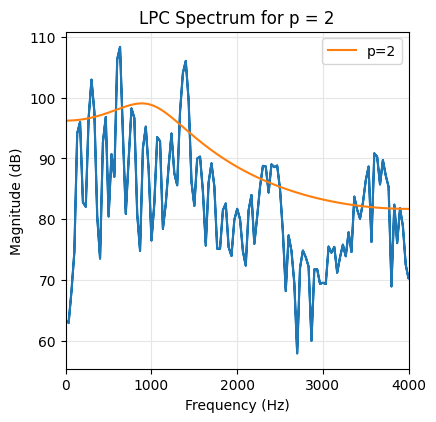

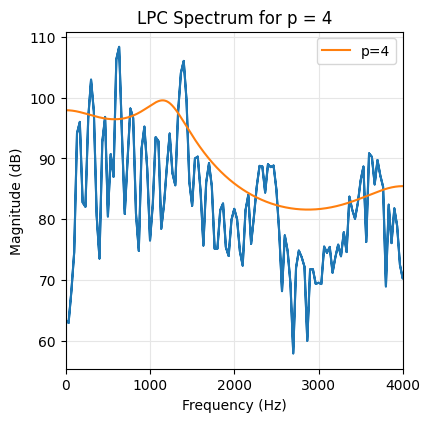

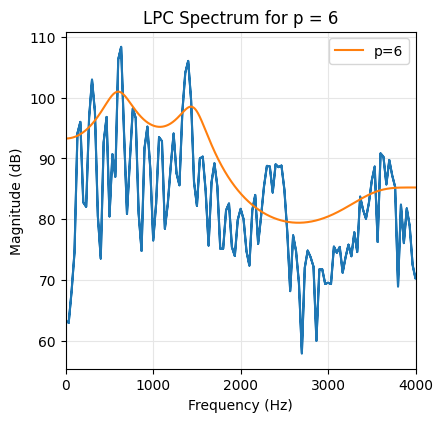

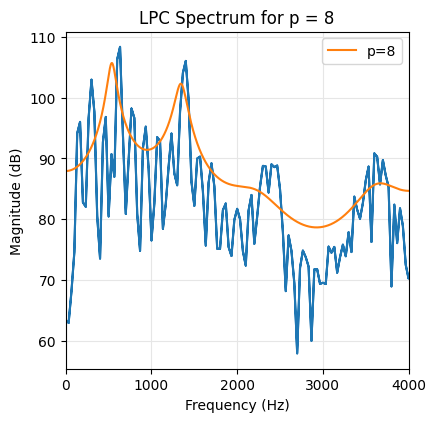

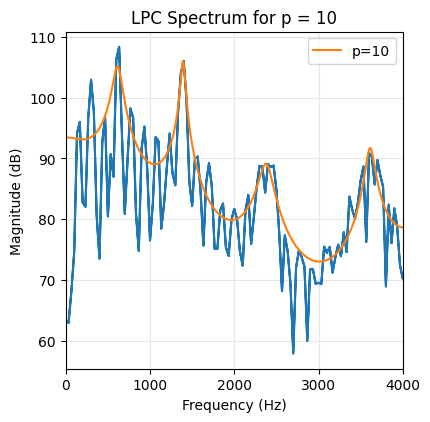

In [98]:
# Define LPC orders (p values)
p_values = [2, 4, 6, 8, 10]

# Initialize arrays to store LPC spectra
lpc_spectra = {}

# Compute LPC spectra for each order p
for p in p_values:

    # Computing the frequency response of the LPC filter
    deno = [a[p][0],*(-a[p][1:p+1])]
    nume = gain_values[p]
    w, h = freqz(nume, deno, worN=8000)

    # Storing the magnitude spectrum
    lpc_spectra[p] = 20 * np.log10(np.abs(h))

for p in p_values:
    plt.figure(figsize=(12, 8))
    plt.suptitle("")
    plt.subplot(2,3,p // 2 +1)
    plt.plot(abs(frequency_axis), 20 * np.log10(magnitude_spectrum))
    plt.plot(w * sample_rate / (2 * np.pi), lpc_spectra[p], label=f'p={p}')

    plt.title("LPC Spectrum for p = {}".format(p))
    plt.grid(color='0.9', linestyle='-')
    plt.xlim(xmin=-5)
    plt.legend(loc="best")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.tight_layout()
    plt.show()


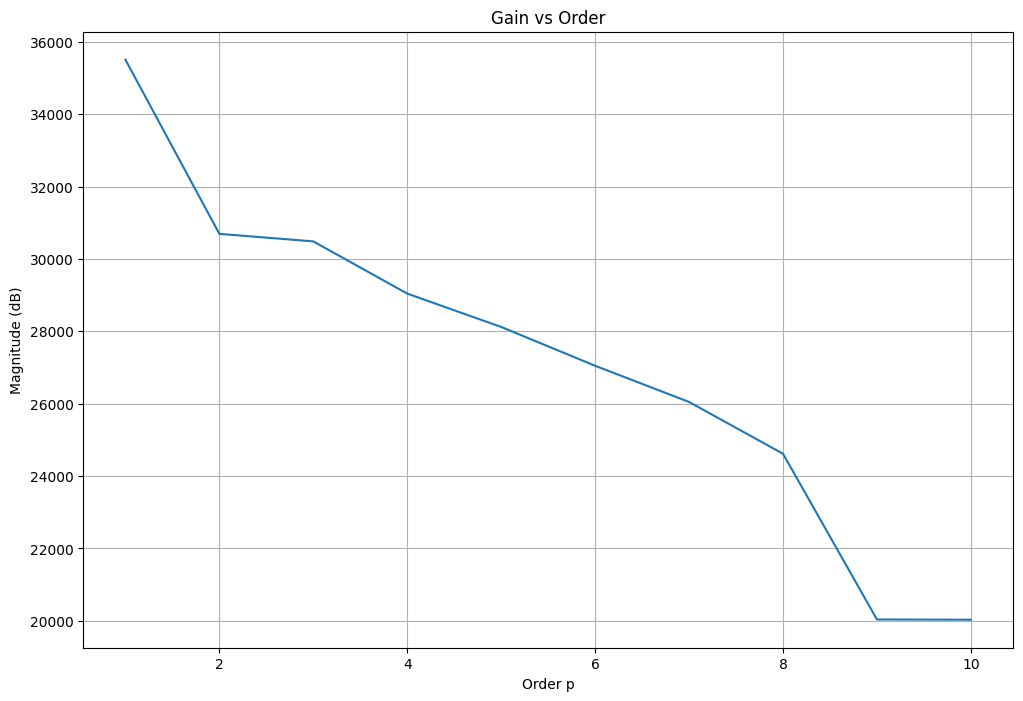

In [99]:
# Plotting the gains
plt.figure(figsize=(12, 8))
plt.plot(x[1:], gain_values[1:])
plt.xlabel('Order p')
plt.ylabel('Magnitude (dB)')
plt.title('Gain vs Order')
plt.grid()

Que 6. Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel segment to obtain the residual error signal. Can you measure the pitch period of the voiced sound from
the residual waveform? Use the acf to detect the pitch. Compare the acf plots of the original
speech and residual signals.

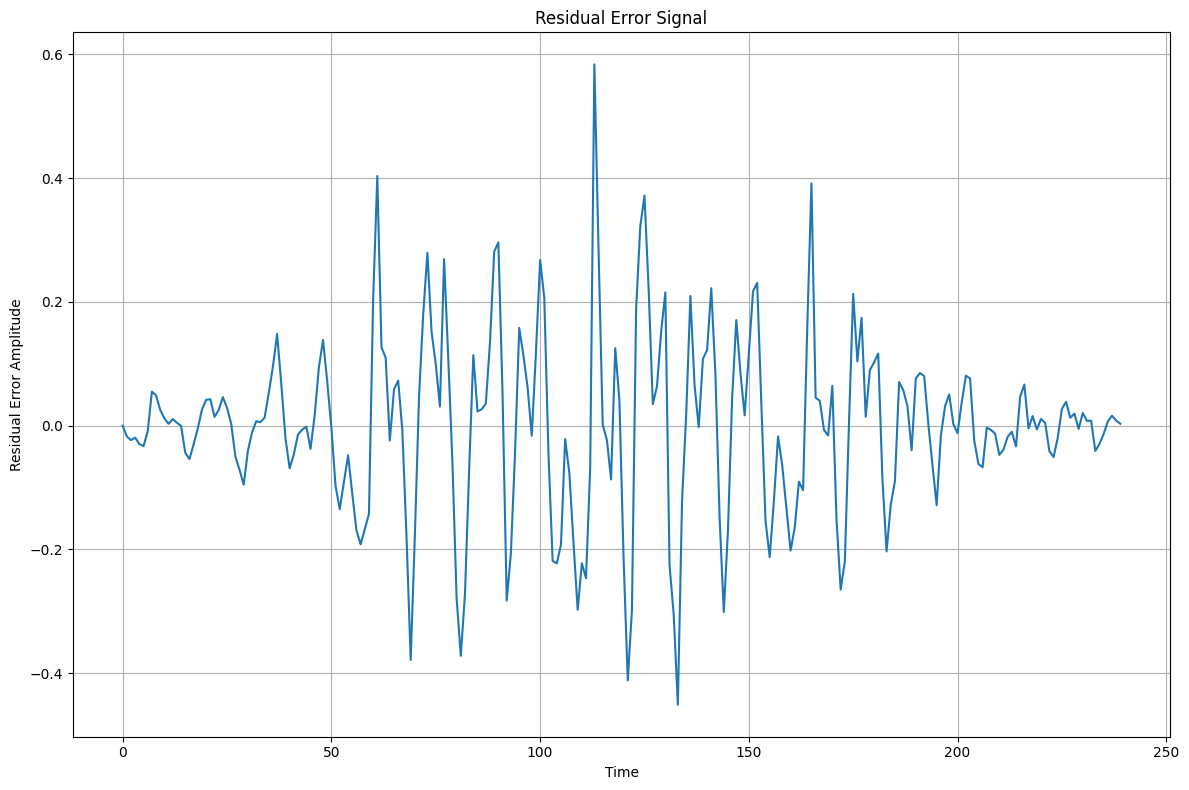

In [100]:
p = 10

inverse_filter_signal = np.zeros_like(segment)

# Calculating the inverse filter
length = segment.shape[0]
for i in range(length):
    inverse_filter_signal[i] = segment[i]
    for j in range(p+1):
        if (i-j) > -1 :
            inverse_filter_signal[i] = inverse_filter_signal[i] - a[p][j]*segment[i-j]
    inverse_filter_signal[i] = inverse_filter_signal[i] / gain_values[p]

plt.figure(figsize=(12, 8))
plt.plot(inverse_filter_signal)
plt.title("Residual Error Signal")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Residual Error Amplitude")
plt.tight_layout()
plt.show()

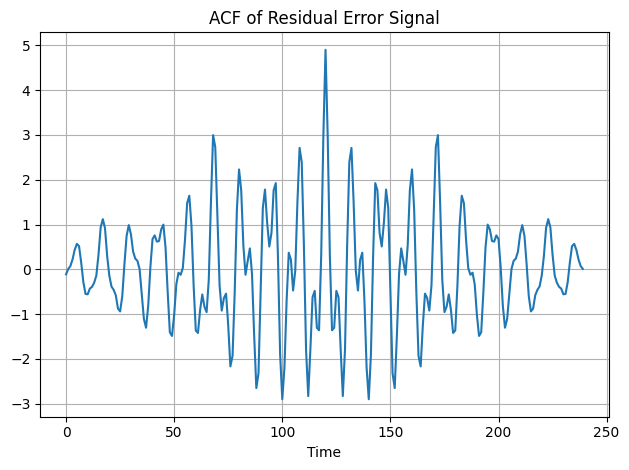

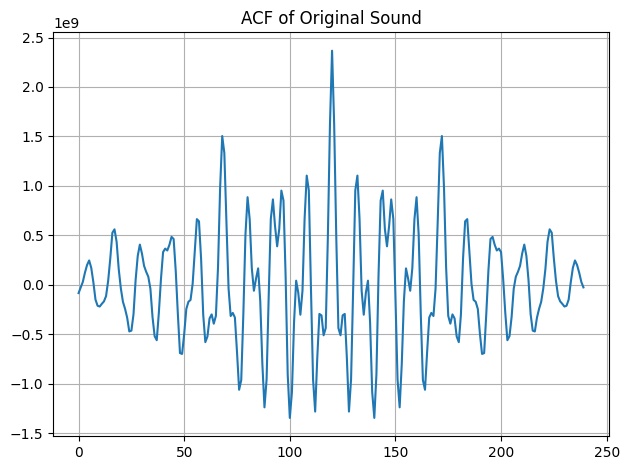

153.84615384615384


In [102]:
inverse_signal_auto = np.correlate(inverse_filter_signal,inverse_filter_signal,mode="same")
signal_auto = np.correlate(segment,segment,mode="same")

max1 = np.argmax(inverse_signal_auto)
max2 = np.argmax(inverse_signal_auto[inverse_signal_auto <0.7* np.max(inverse_signal_auto)])

pitch = (sample_rate/(max1 - max2))


plt.title("ACF of Residual Error Signal")
plt.plot(inverse_signal_auto)
plt.grid()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

plt.title("ACF of Original Sound")
plt.plot(signal_auto)
plt.grid()
plt.tight_layout()
plt.show()

print(pitch)

Que 7. LP re-synthesis: We analysed a natural speech sound /uh/ above. Using a suitable set of parameter estimates as obtained there, we wish to reconstruct the sound.

That is, use the best estimated LP filter with an ideal impulse train of the estimated pitch period as source excitation. Carry out de-emphasis on the output waveform. Set the duration of the synthesized sound to be 300 ms at 8 kHz sampling frequency and view the waveform as well as listen to your created sound.

Comment on the similarity with the original sound. Try out voice modification using this analysis-synthesis method (e.g. change the voice pitch).

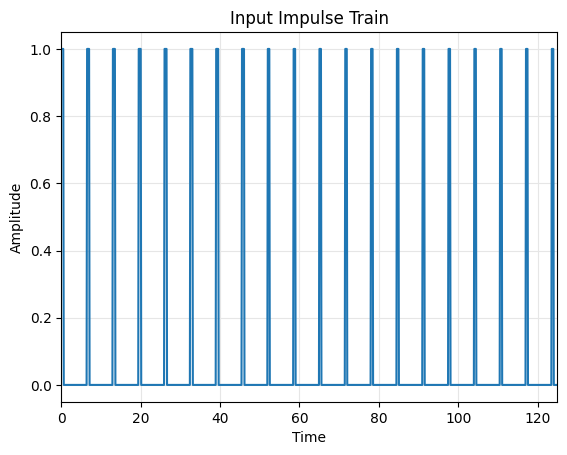

In [103]:
period = pitch / 1000
sound_duration = 300

total_duration = int((sound_duration/1000)*sample_rate)
t = np.linspace(0, sound_duration ,total_duration)
impulse_train = (signal.square(2 * np.pi *period * t,duty=0.08)+1)/2
plt.figure()
plt.title("Input Impulse Train")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(t[:1000], impulse_train[:1000])
plt.grid(color='0.9', linestyle='-')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

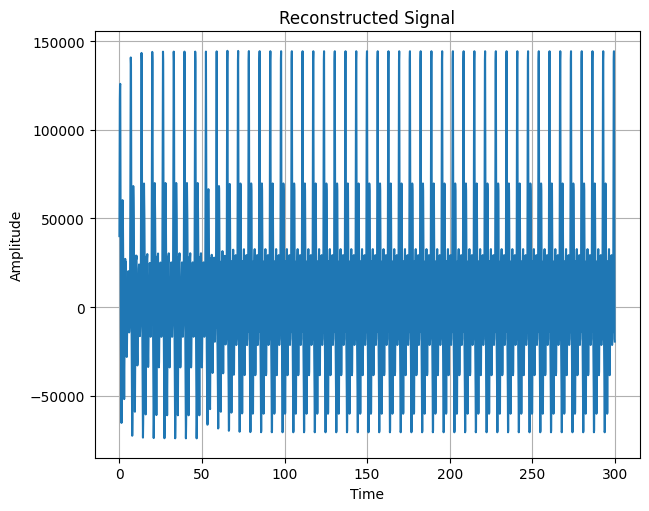

In [104]:
reconstructed_signal = np.zeros_like(impulse_train)
for i in range(len(impulse_train)):
    reconstructed_signal[i] = gain_values[10]*impulse_train[i]
    for j in range(len(a[10])):
        if (i-j)> -1:
            reconstructed_signal[i] += a[10][j]*reconstructed_signal[i-j]

plt.figure()
plt.plot(t,reconstructed_signal)
plt.grid()
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Reconstructed Signal")
plt.show()


In [105]:
wavfile.write("/content/drive/MyDrive/Assignment2_Speech/sounds"+str(p)+".wav",8000,reconstructed_signal)

Que 8. Perform LP analysis on the provided /s/ sound (sampled at 16 kHz).

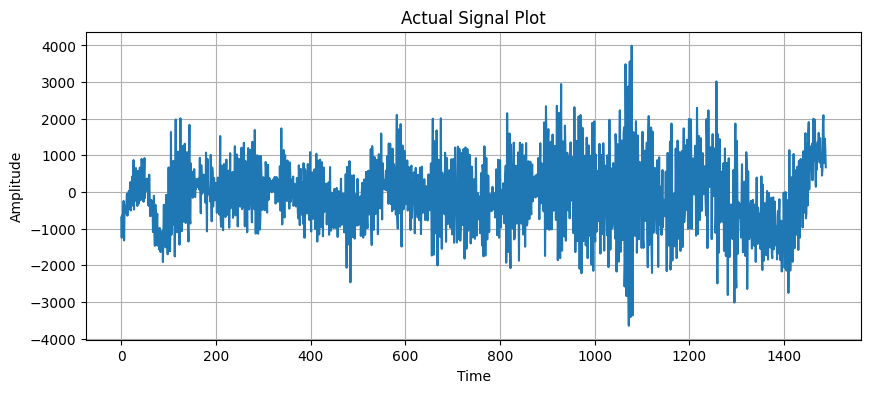

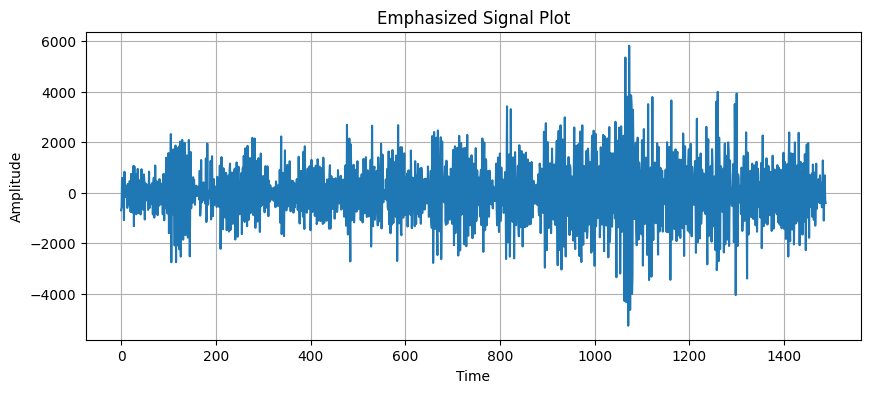

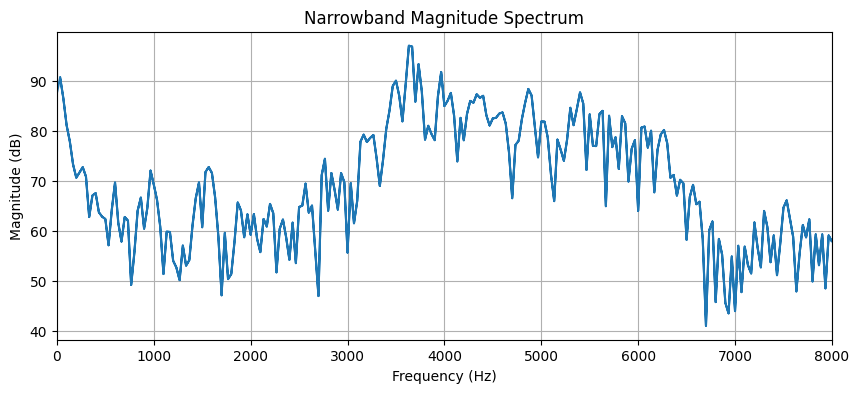

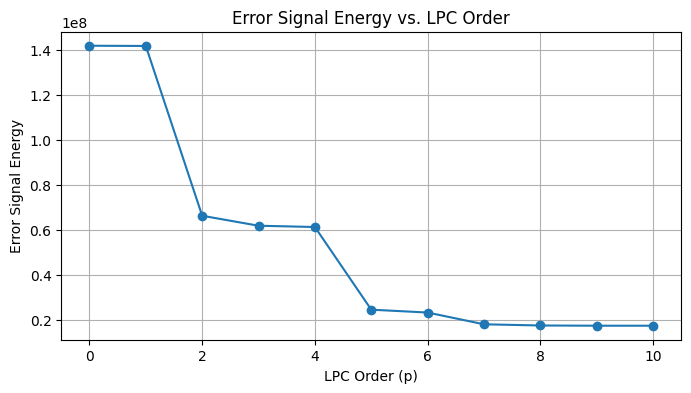

<Figure size 1200x400 with 0 Axes>

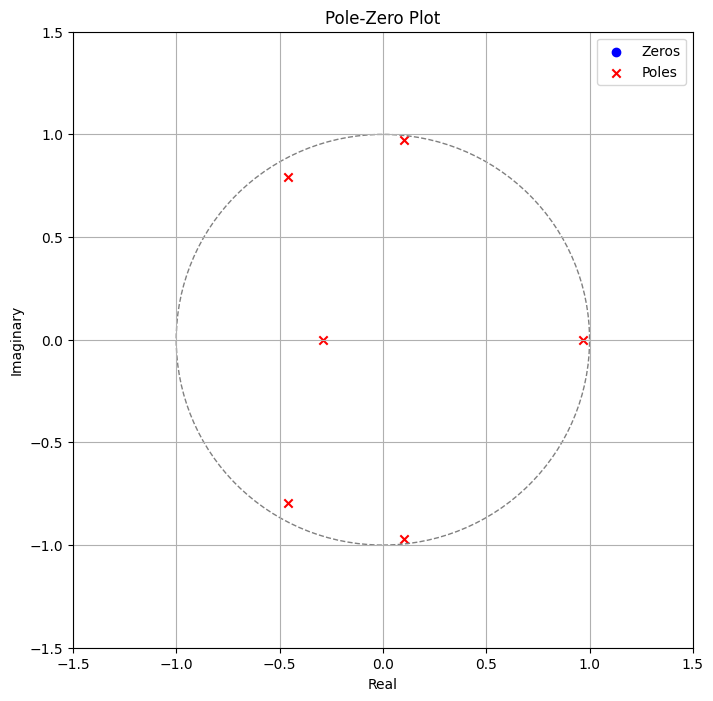

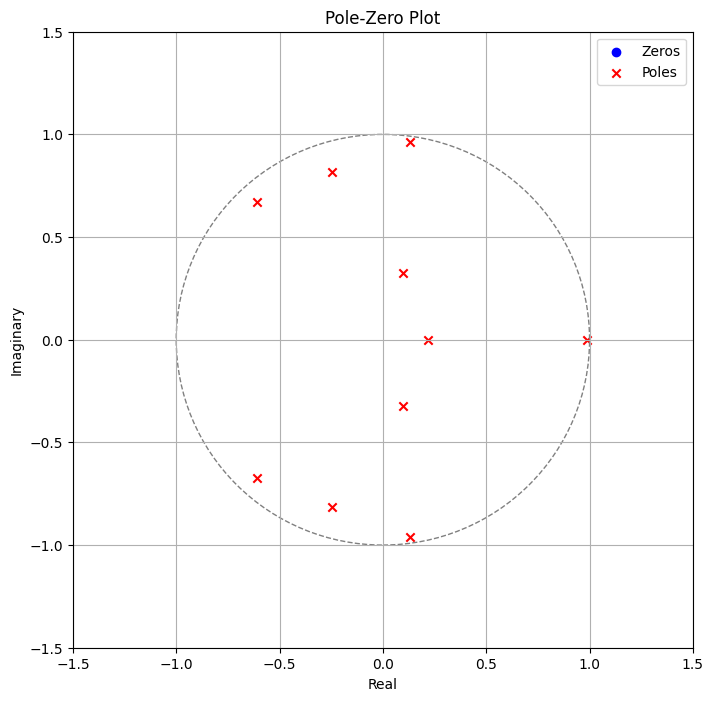

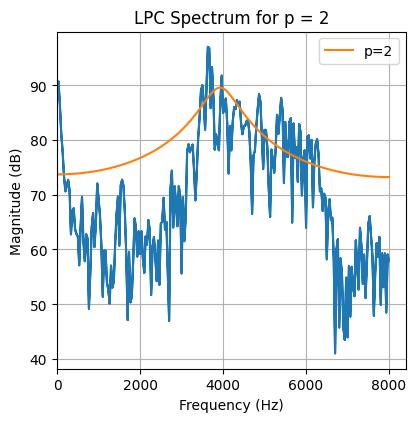

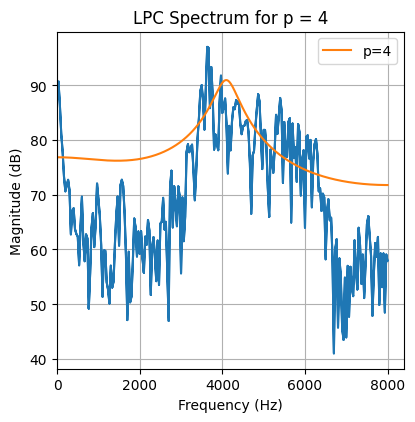

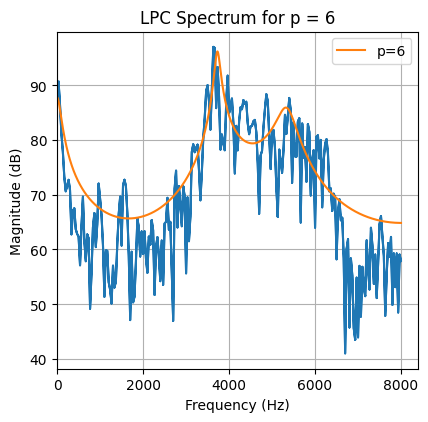

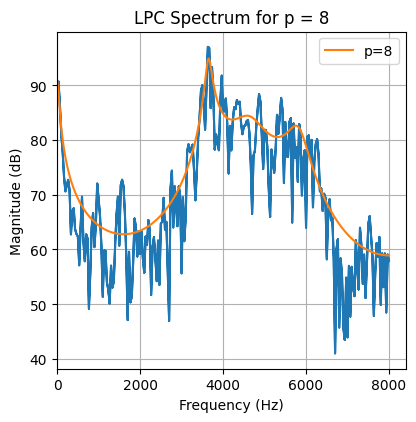

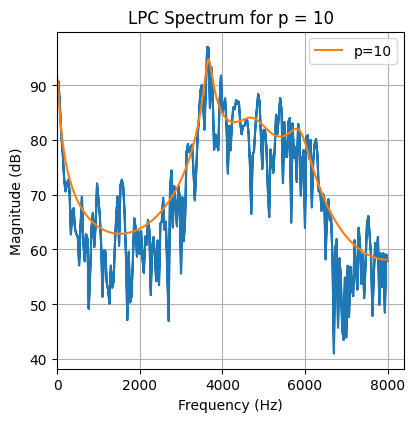

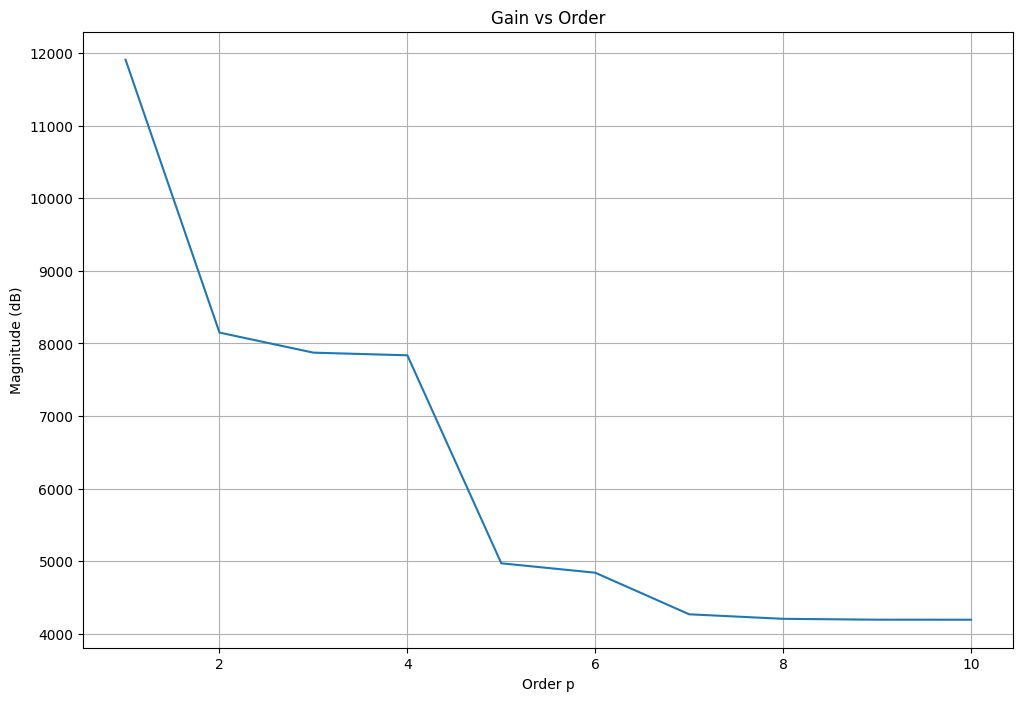

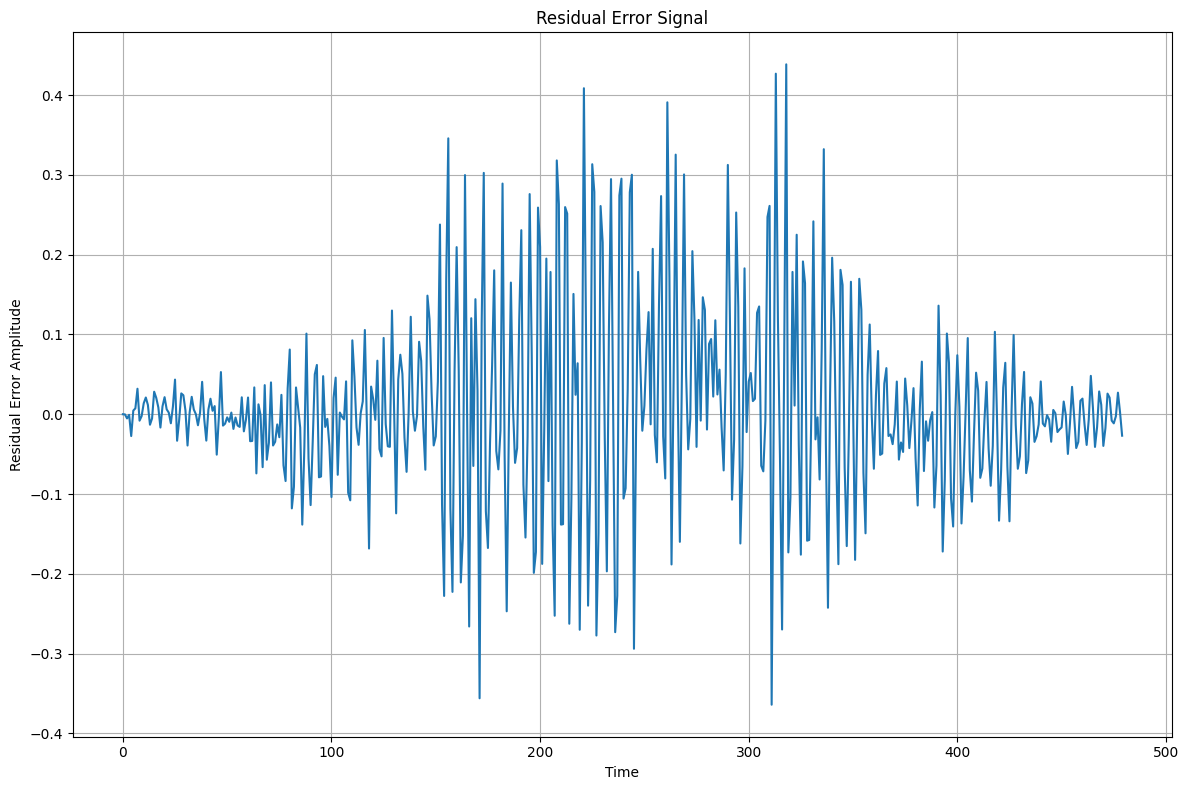

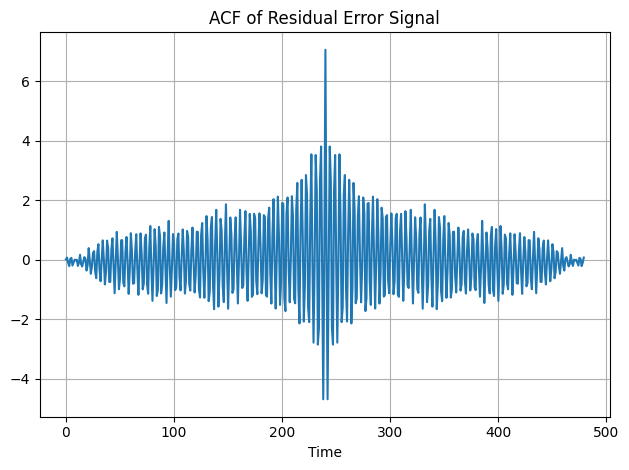

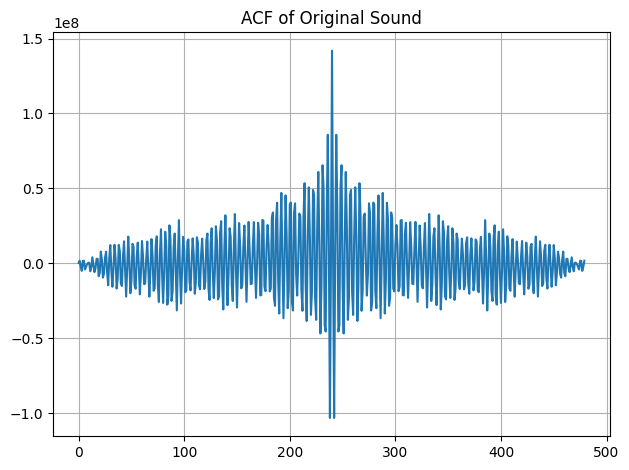

4000.0


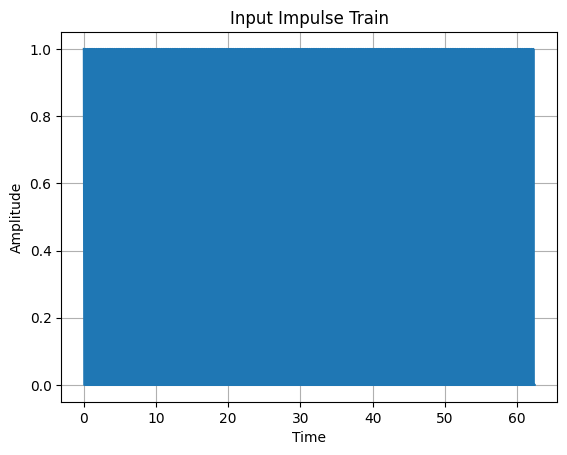

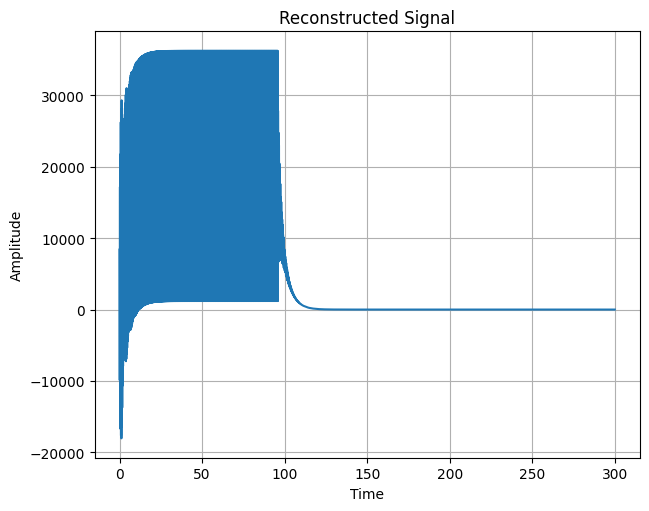

In [108]:
# Loading the audio file and finding it's signal and sample rate
audio_file = '/content/drive/MyDrive/Assignment2_Speech/sounds/ss.wav'
sample_rate, audio_signal = wavfile.read(audio_file)

# Defining the pre-emphasis coefficient
alpha = 0.97

# Applying pre-emphasis to the audio signal
emphasized_signal = np.append(audio_signal[0], audio_signal[1:] - alpha * audio_signal[:-1])

# Now, 'emphasized_signal' contains the pre-emphasized audio data

plt.figure(figsize=(10, 4))
plt.plot(audio_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Actual Signal Plot')
plt.grid()
plt.show()


plt.figure(figsize=(10, 4))
plt.plot(emphasized_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Emphasized Signal Plot')
plt.grid()
plt.show()


# Defining the window duration in seconds and window size
window_duration = 0.03  # 30 ms
window_size = int(window_duration * sample_rate)

# Selecting a segment near the center of the audio
center_sample = len(audio_signal) // 2
segment_start = center_sample - window_size // 2
segment_end = center_sample + window_size // 2

# Applying a Hamming window to the segment
hamming_window = np.hamming(window_size)
segment = audio_signal[segment_start:segment_end] * hamming_window

# Computing the magnitude spectrum using FFT
magnitude_spectrum = np.abs(np.fft.fft(segment))

# Frequency axis in Hertz
frequency_axis = np.fft.fftfreq(window_size, d=1.0 / sample_rate)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 4))
plt.plot(abs(frequency_axis), 20 * np.log10(magnitude_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Narrowband Magnitude Spectrum')
plt.grid()
plt.xlim(0, sample_rate / 2)  # Displaying only positive frequencies
plt.show()

# Defining the order ( p = 10) this will also calculate other orders
p = 10

# Compute autocorrelation coefficients for each order p
autocorr = np.correlate(segment, segment, mode='full')
a = np.zeros((11,11))
gain_values = np.zeros(11)

r = autocorr[len(segment) - 1:len(segment) - 1 + p + 1]  # Autocorrelation coefficients up to order p
E = np.zeros(11)

# Levinson-Durbin recursion to compute LPC coefficients
a[0][0] = 1
E[0] = r[0]
for i in range(1, p + 1):
    c = 0
    for j in range (1, i):
      c += a[i-1][j] * r[i-j]
    k = (r[i] - c) / E[i-1]
    a[i][i] = k
    for j in range(1, i):
      a[i][j] = a[i-1][j] - k * a[i-1][i-j]
    E[i] = E[i - 1] * (1 - k * k)
    gain_values[i] = np.sqrt(E[i])
    a[i][0] = 1

x = [i for i in range(p+1)]
# Plotting error signal energy vs. LPC order (p)
plt.figure(figsize=(8, 4))
plt.plot(x, E, marker='o', linestyle='-')
plt.xlabel('LPC Order (p)')
plt.ylabel('Error Signal Energy')
plt.title('Error Signal Energy vs. LPC Order')
plt.grid()
plt.show()


from scipy.signal import lfilter, freqz
from scipy import signal

# Defining LPC orders for which we will calculate Pole Zero plots
p_values = [6, 10]

# Plotting the pole-zero plots
plt.figure(figsize=(12, 4))
for p in p_values:
    # Compute the poles and zeros
    den = [a[p][0],*(-a[p][1:p+1])]
    num = gain_values[p]

    # Calculating the poles and zeros
    zeros, poles, _ = signal.tf2zpk(num, den)

    # Creating a pole-zero plot
    plt.figure(figsize=(8, 8))
    plt.scatter(np.real(zeros), np.imag(zeros), marker='o', color='b', label='Zeros')
    plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', label='Poles')

    # Adding a unit circle for reference
    unit_circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='dashed')
    plt.gca().add_patch(unit_circle)

    # Setting axis limits and labels
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

    # Adding legend
    plt.legend()

    # Addding a title
    plt.title('Pole-Zero Plot')

    # Showing the plot
    plt.grid()
    plt.show()



# Define LPC orders (p values)
p_values = [2, 4, 6, 8, 10]

# Initialize arrays to store LPC spectra
lpc_spectra = {}

# Compute LPC spectra for each order p
for p in p_values:

    # Computing the frequency response of the LPC filter
    deno = [a[p][0],*(-a[p][1:p+1])]
    nume = gain_values[p]
    w, h = freqz(nume, deno, worN=8000)

    # Storing the magnitude spectrum
    lpc_spectra[p] = 20 * np.log10(np.abs(h))

for p in p_values:
    plt.figure(figsize=(12, 8))
    plt.suptitle("")
    plt.subplot(2,3,p // 2 +1)
    plt.plot(abs(frequency_axis), 20 * np.log10(magnitude_spectrum))
    plt.plot(w * sample_rate / (2 * np.pi), lpc_spectra[p], label=f'p={p}')

    plt.title("LPC Spectrum for p = {}".format(p))
    plt.grid()
    plt.xlim(xmin=-5)
    plt.legend(loc="best")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.tight_layout()
    plt.show()


# Plotting the gains
plt.figure(figsize=(12, 8))
plt.plot(x[1:], gain_values[1:])
plt.xlabel('Order p')
plt.ylabel('Magnitude (dB)')
plt.title('Gain vs Order')
plt.grid()
plt.show()


p = 10

inverse_filter_signal = np.zeros_like(segment)

# Calculating the inverse filter
length = segment.shape[0]
for i in range(length):
    inverse_filter_signal[i] = segment[i]
    for j in range(p+1):
        if (i-j) > -1 :
            inverse_filter_signal[i] = inverse_filter_signal[i] - a[p][j]*segment[i-j]
    inverse_filter_signal[i] = inverse_filter_signal[i] / gain_values[p]

plt.figure(figsize=(12, 8))
plt.plot(inverse_filter_signal)
plt.title("Residual Error Signal")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Residual Error Amplitude")
plt.tight_layout()
plt.show()


inverse_signal_auto = np.correlate(inverse_filter_signal,inverse_filter_signal,mode="same")
signal_auto = np.correlate(segment,segment,mode="same")

max1 = np.argmax(inverse_signal_auto)
max2 = np.argmax(inverse_signal_auto[inverse_signal_auto <0.7* np.max(inverse_signal_auto)])

pitch = (sample_rate/(max1 - max2))

plt.title("ACF of Residual Error Signal")
plt.plot(inverse_signal_auto)
plt.grid()
plt.xlabel("Time")
plt.tight_layout()
plt.show()

plt.title("ACF of Original Sound")
plt.plot(signal_auto)
plt.grid()
plt.tight_layout()
plt.show()

print(pitch)

period = pitch / 1000
sound_duration = 300

total_duration = int((sound_duration/1000)*sample_rate)
t = np.linspace(0, sound_duration ,total_duration)
impulse_train = (signal.square(2 * np.pi *period * t,duty=0.08)+1)/2
plt.figure()
plt.title("Input Impulse Train")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(t[:1000], impulse_train[:1000])
plt.grid()
plt.show()


reconstructed_signal = np.zeros_like(impulse_train)
for i in range(len(impulse_train)):
    reconstructed_signal[i] = gain_values[10]*impulse_train[i]
    for j in range(len(a[10])):
        if (i-j)> -1:
            reconstructed_signal[i] += a[10][j]*reconstructed_signal[i-j]

plt.figure()
plt.plot(t,reconstructed_signal)
plt.grid()
plt.tight_layout()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Reconstructed Signal")
plt.show()

wavfile.write("/content/drive/MyDrive/Assignment2_Speech/sounds"+str(p)+str('last')+".wav",16000,reconstructed_signal)
